### String stability test: Speed deviation

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import os
import numpy as np
import matplotlib.colors as mcolors

# Plot styling
axes_size = 26
tick_size = 22
rcParams["text.usetex"] = True
rcParams["font.family"] = "serif"
rcParams["font.serif"] = ["Times"]
rcParams["font.size"] = tick_size
rcParams["axes.labelsize"] = axes_size
rcParams["xtick.labelsize"] = tick_size
rcParams["ytick.labelsize"] = tick_size
rcParams["legend.fontsize"] = tick_size

# Load data
file_path = '../output/straight/latest_100_IDM_FS_followers_7.csv'
df = pd.read_csv(file_path)

### Plotting relative speed and spacing

In [6]:
def plot_relative_deviation(csv_path, metric='speed', freq=10, xlim=(0, None), ylim=(None, None),
                                  save_pdf=False, save_path=None, fig_size=(10, 3), dpi=300):
    """
    Plot relative deviation (speed or space headway) between successive vehicles.

    Parameters:
    - metric: 'speed' or 'headway'
    """
    assert metric in ['speed', 'headway'], "Metric must be 'speed' or 'headway'"

    df = pd.read_csv(csv_path)
    df_small = df[['time_step', 'vehicle_id', 'role', 'speed_mps', 'space_headway']]

    if metric == 'speed':
        data_df = df_small.pivot(index='time_step', columns='role', values='speed_mps')
        ylabel = r"\textbf{Relative Speed (m/s)}"
        title = r"\textbf{Relative Speed ($\Delta v$) Between Successive Vehicles Over Time}"

    elif metric == 'headway':
        # Do not compute deviation for headway, just plot directly
        data_df = df_small.pivot(index='time_step', columns='role', values='space_headway')
        # Drop Leader since its headway is always zero
        data_df = data_df.drop(columns='Leader', errors='ignore')
        ylabel = r"\textbf{Space Headway (m)}"
        title = r"\textbf{Space Headway ($\Delta x$) Between Successive Vehicles Over Time}"
        relative_dev = data_df  # No deviation computation
    else:
        raise ValueError("Invalid metric")

    # For speed, compute relative deviation (predecessor - current)
    if metric == 'speed':
        sorted_roles = ['Leader'] + sorted([col for col in data_df.columns if col != 'Leader'])
        relative_dev = {}
        for i in range(1, len(sorted_roles)):
            curr_role = sorted_roles[i]
            prev_role = sorted_roles[i - 1]
            relative_dev[curr_role] = data_df[prev_role] - data_df[curr_role]
        relative_dev = pd.DataFrame(relative_dev, index=data_df.index)

    # Convert time_step to seconds
    time_sec = relative_dev.index * (1 / freq)

    # Plotting
    custom_colors = ['#38028F', '#8F0202', '#8F0244', '#02448F', '#028F4A', '#8F6A02', "#00B1B8"]
    n_colors = len(custom_colors)


    plt.figure(figsize=fig_size)

    for idx, col in enumerate(relative_dev.columns):
        #LaTeX label
        if metric=="speed":
            label = fr'$\Delta v_{{{idx+1}}}(t)$'
        else:
            label = fr'$\Delta x_{{{idx+1}}}(t)$'
        color = custom_colors[idx % n_colors]
        plt.plot(time_sec, relative_dev[col], label=label, linestyle='-', linewidth=1, color=color)


    plt.xlabel(r"\textbf{Time (s)}")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc="upper right" ,ncols=2)
    plt.grid(True)

    # Add text annotations
    switch_time=120

    if metric=="speed":
        plt.axvline(x=switch_time, color='purple', linestyle='--', linewidth=1)
        plt.text(switch_time - 80, 3.5, "Manual Driving", 
                fontsize=22, ha='center', va='top', color='black')
        plt.text(switch_time + 70, 3.5, "Mixed Autonomy", 
                fontsize=22, ha='center', va='top', color='black')
        plt.text(switch_time+2, -3.5, "FS Activation", fontsize=22, rotation=90, color='purple')
    else:
        plt.axvline(x=switch_time, color='purple', linestyle='--', linewidth=1)
        plt.text(switch_time - 50, plt.ylim()[1]*0.65, "Manual Driving", 
                fontsize=22, ha='center', va='top', color='black')
        plt.text(switch_time + 70, plt.ylim()[1]*0.65, "Mixed Autonomy", 
                fontsize=22, ha='center', va='top', color='black')
        plt.text(switch_time+2, plt.ylim()[1]*0.65, "FS Activation", fontsize=22, rotation=90, color='purple')

    if xlim[0] is not None or xlim[1] is not None:
        plt.xlim(left=xlim[0], right=xlim[1])
    if ylim[0] is not None or ylim[1] is not None:
        plt.ylim(bottom=ylim[0], top=ylim[1])

    plt.tight_layout()

    if save_pdf:
        if save_path is None:
            save_path = f"{metric}_deviation.pdf"
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=dpi, format="pdf", bbox_inches='tight')
        print(f"Plot saved to: {save_path}")

    plt.show()

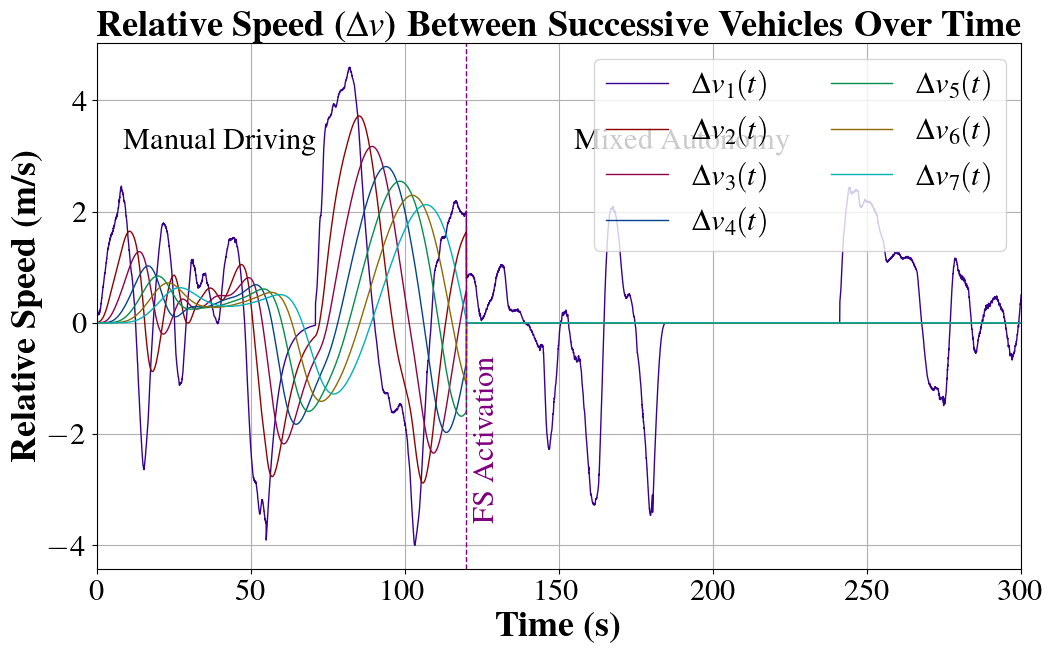

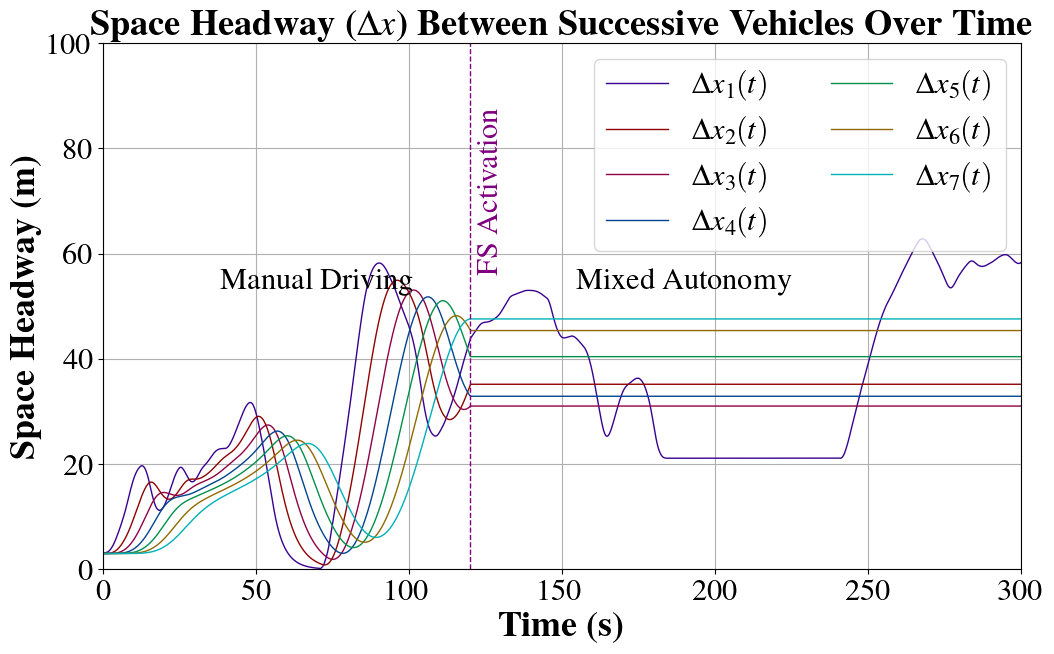

In [13]:
csv_path = "../output/straight/04092025_latest_50_IDM_FS_followers_7.csv"
fig_w = 11
fig_h = 7
x_lim = 300

# For speed deviation plot
plot_relative_deviation(
    csv_path=csv_path,
    metric='speed',
    freq = 50,
    xlim=(0, x_lim),
    ylim=(None,None),
    save_pdf=False,
    fig_size=(fig_w, fig_h),
    save_path="../figures/straight/string_stability_test/relative_speed_deviation.pdf"
)

# For headway plot
plot_relative_deviation(
    csv_path=csv_path,
    metric='headway',
    freq = 50,
    xlim=(0, x_lim),
    ylim=(0,100),
    save_pdf=False,
    fig_size=(fig_w, fig_h),
    save_path="../figures/straight/string_stability_test/space_deviation.pdf"
)

## String stability test

### 1. Head to Tail amplification

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

def compute_head_to_tail_amplification_window(csv_path, t_start_s, t_end_s, freq=100, xlim=(0, None), ylim=(None, None),
                                  save_pdf=False, save_path=None, fig_size=(10, 3), dpi=300):
    """
    Compute head-to-tail amplification A over selected time window.

    Parameters:
    - csv_path: path to CSV file
    - v_eq: equilibrium (reference) speed, e.g., 35 m/s
    - t_start_s: start time in seconds
    - t_end_s: end time in seconds
    - time_step_size: time step size in seconds (default 0.1s)
    - plot: whether to plot per-time-step amplification

    Returns:
    - summary dict with max A, mean A, % time A>1
    """
    # Load data
    df = pd.read_csv(csv_path)
    df_small = df[['time_step', 'vehicle_id', 'role', 'speed_mps']]
    
    # Pivot to wide format
    speed_df = df_small.pivot(index='time_step', columns='role', values='speed_mps')
    
    # Slice time window
    time_step_size = 1/freq
    t_start_idx = int(t_start_s / time_step_size)
    t_end_idx = int(t_end_s / time_step_size)
    window_df = speed_df.iloc[t_start_idx:t_end_idx]

    # Compute absolute deviation from equilibrium
    leader_dev = window_df['Leader']
    last_dev = window_df['Follower6']

    # Per-time-step amplification A_t
    A_t = last_dev / leader_dev.replace(0, pd.NA)  # avoid division by zero
    A_t = A_t.fillna(0)  # fill div0 as 0 or you can skip

    # Summary stats
    max_A = A_t.max()
    mean_A = A_t.mean()
    min_A = A_t.min()
    percent_A_lt1 = (A_t < 1).mean() * 100

    print(f"Time Window: {t_start_s}s to {t_end_s}s")
    print(f"Max. Amplification A_t: {max_A:.3f}")
    print(f"Mean Amplification A_t: {mean_A:.3f}")
    print(f"Min. Amplification A_t: {min_A:.3f}")
    print(f"Percentage of Time A_t < 1: {percent_A_lt1:.3f}%")


    time_sec = window_df.index * time_step_size
    plt.figure(figsize=(10, 4))
    plt.plot(time_sec, A_t, label='Amplification A_t', color='darkred')
    plt.axhline(1, color='gray', linestyle='--', label='A=1 threshold')
    plt.xlabel(r'Time (s)')
    plt.ylabel(r'A_t (Follower6 / Leader)')
    plt.title(r'Per-Time-Step Amplification Over Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    if xlim[0] is not None or xlim[1] is not None:
        plt.xlim(left=xlim[0], right=xlim[1])
    if ylim[0] is not None or ylim[1] is not None:
        plt.ylim(bottom=ylim[0], top=ylim[1])

    plt.tight_layout()

    if save_pdf:
        if save_path is None:
            save_path = f"head_to_tail_amplification.pdf"
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=dpi, format="pdf")
        print(f"Plot saved to: {save_path}")

    plt.show()

    return {'max_A': max_A, 'mean_A': mean_A, 'percent_A_gt1': percent_A_lt1}


Time Window: 400s to 500s
Max. Amplification A_t: 1.021
Mean Amplification A_t: 1.002
Min. Amplification A_t: 0.993
Percentage of Time A_t < 1: 39.660%


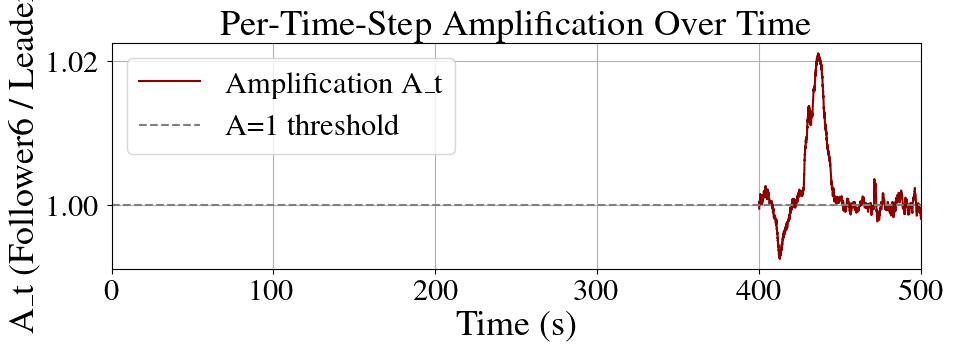

{'max_A': np.float64(1.021089812443196),
 'mean_A': np.float64(1.0020887357463952),
 'percent_A_gt1': np.float64(39.660000000000004)}

In [10]:
csv_path = "../output/straight/latest_50_IDM_FS_followers_7.csv"
fig_w = 11
fig_h = 6
x_lim = 500

compute_head_to_tail_amplification_window(
    csv_path,
    t_start_s=400,
    t_end_s=500,
    freq = 50,
    xlim=(0, 500),
    ylim=(None,None),
    save_pdf=False,
    fig_size=(fig_w, fig_h),
    save_path="../figures/straight/string_stability_test/relative_speed_deviation_r30.pdf"
)

In [11]:
def compute_head_to_tail_amplification(csv_path):
    """
    Compute Head-to-Tail Amplification metric A:
    A = max(|v_last(t) - veq|) / max(|v_leader(t) - veq|)

    Parameters:
        csv_path (str): Path to the CSV log file
        veq (float or None): Equilibrium speed (if None, use average leader speed)

    Returns:
        float: Amplification ratio A
    """
    # Load CSV
    df = pd.read_csv(csv_path)
    #df = df.iloc[:]

    # Filter relevant columns
    df = df[['time_step', 'role', 'speed_mps']]
    print(df)
    veq = df['speed_mps'].mean()

    print(f"Equlibrium velocity: {veq}")

    # Pivot for easy access
    pivot_df = df.pivot(index='time_step', columns='role', values='speed_mps').dropna()

    # Get leader and last follower
    leader_speed = pivot_df['Leader'].values
    follower_names = sorted([col for col in pivot_df.columns if col != 'Leader'])
    last_follower_speed = pivot_df[follower_names[-1]].values

    # Determine equilibrium speed if not provided
    if veq is None:
        veq = np.mean(leader_speed)

    # Compute deviations
    leader_dev = np.abs(leader_speed - veq)
    last_follower_dev = np.abs(last_follower_speed - veq)

    # Compute amplification
    amplification = np.max((last_follower_dev) / np.max(leader_dev))

    return amplification

In [12]:
csv_path = "../output/straight/latest_50_IDM_FS_followers_7.csv"
amp = compute_head_to_tail_amplification(csv_path)
print(f"A_t: {amp}")

        time_step       role  speed_mps
0               0     Leader     0.0500
1               0  Follower1     0.0408
2               0  Follower2     0.0408
3               0  Follower3     0.0408
4               0  Follower4     0.0408
...           ...        ...        ...
199995      24999  Follower3    27.8566
199996      24999  Follower4    27.8566
199997      24999  Follower5    27.8566
199998      24999  Follower6    27.8566
199999      24999  Follower7    27.8566

[200000 rows x 3 columns]
Equlibrium velocity: 15.678914753
A_t: 0.9939257365282067


## Freq domain SS

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

def compute_transfer_ratio(leader_speed, follower_speed, dt):
    N = len(leader_speed)
    freq = fftfreq(N, d=dt)

    # FFT of leader and follower speeds
    L_fft = fft(leader_speed)
    F_fft = fft(follower_speed)

    # Transfer function magnitude
    magnitude_ratio = np.abs(F_fft) / (np.abs(L_fft) + 1e-6)  # Avoid divide-by-zero

    return freq[:N // 2], magnitude_ratio[:N // 2]  # Return only positive frequencies

def freq_string_stability(csv_path, target_col, dt=0.02):
    df = pd.read_csv(csv_path)
    df = df.iloc[6000:20000]
    df = df[['time_step', 'role', target_col]]

    # Get unique followers (excluding leader)
    follower_roles = sorted([n for n in df['role'].unique() if n != 'Leader'])

    # Pivot dataframe
    pivot_df = df.pivot(index='time_step', columns='role', values=target_col)
    leader_speed = pivot_df['Leader'].values

    # Plot transfer magnitude for each follower
    plt.figure(figsize=(12, 6))
    for idx, follower in enumerate(follower_roles):
        follower_speed = pivot_df[follower].values
        freq, ratio = compute_transfer_ratio(leader_speed, follower_speed, dt)
        plt.plot(freq, ratio, label=r"del_v: follower"+f"{idx+1}")
        leader_speed = follower_speed  # propagate

    plt.xlabel('Frequency (Hz)')
    plt.ylabel(r'Magnitude Ratio $|V_f(j\omega)| / |V_l(j\omega)|$')
    plt.title(r'String Stability via Transfer Function ($v$ in m/s)')

    plt.title('String Stability via Transfer Function (speed in m/s)')

    plt.grid(True)
    plt.legend()
    plt.xlim(0, None)
    plt.ylim(0, 2)
    plt.axhline(y=1.0, color='r', linestyle='--', label='Unity Gain')
    plt.show()
    #plt.savefig(f"Reports/transfer_function_stability_{target_col}.png")


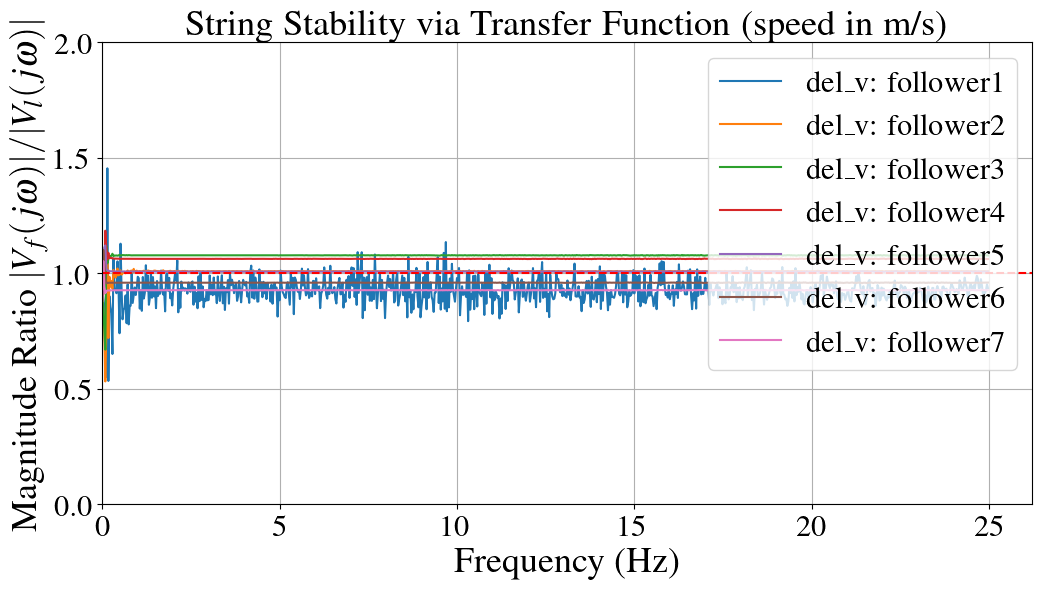

In [12]:
csv_path = "../output/straight/latest_50_IDM_FS_followers_7.csv"
freq_string_stability(csv_path, "speed_mps", dt=0.02)

In [25]:
import json

def time_domain_string_stability(csv_path,target_col):
    # Load and filter data
    df = pd.read_csv(csv_path)
    # df = df[(df['time'] >= start_time) & (df['time'] <= end_time)]
    df = df.iloc[:]
    df = df[['time_step', 'role', target_col]]

    # Pivot table: time as index, vehicle names as columns, speed as values
    pivot_df = df.pivot(index='time_step', columns='role', values=target_col).interpolate().dropna()

    # Reorder columns: leader first, then the rest
    cols = pivot_df.columns.tolist()
    cols.remove('Leader')
    pivot_df = pivot_df[['Leader'] + cols]

    #print(pivot_df)

    # vehicle_names = sorted([col for col in pivot_df.columns if col != 'leader'])
    vehicle_names = [col for col in pivot_df.columns]

    l2_violations = []

    for i in range(1, len(vehicle_names) - 1):
        print(f"Leader vehicle {vehicle_names[i - 1]}")
        print(f"Ego vehicle {vehicle_names[i]}")

        print(f"Follower vehicle {vehicle_names[i + 1]}")
        print(f"--------------------------------------------------")
        v_l = pivot_df[vehicle_names[i - 1]].values
        v_n   = pivot_df[vehicle_names[i]].values
        v_f = pivot_df[vehicle_names[i + 1]].values

        print(len(v_l), len(v_n), len(v_f))

        l2_left  = np.linalg.norm(v_n - v_l)
        l2_right = np.linalg.norm(v_f - v_n)

        #print(l2_left)

        violation = l2_right > l2_left
        l2_violations.append({'Vehicle': vehicle_names[i],'left_norm': float(l2_left),'right_norm': float(l2_right), 'violation': str(violation)})

        # l2_violations.append((vehicle_names[i + 1], l2_left, l2_right, violation))

    with open(f'Reports/time_domain_string_stability.json', 'w') as f:
        json.dump(l2_violations, f, indent=4)

In [26]:
csv_path = "../output/straight/latest_50_IDM_FS_followers_7.csv"
time_domain_string_stability(csv_path, "speed_mps")

Leader vehicle Leader
Ego vehicle Follower1
Follower vehicle Follower2
--------------------------------------------------
25000 25000 25000
Leader vehicle Follower1
Ego vehicle Follower2
Follower vehicle Follower3
--------------------------------------------------
25000 25000 25000
Leader vehicle Follower2
Ego vehicle Follower3
Follower vehicle Follower4
--------------------------------------------------
25000 25000 25000
Leader vehicle Follower3
Ego vehicle Follower4
Follower vehicle Follower5
--------------------------------------------------
25000 25000 25000
Leader vehicle Follower4
Ego vehicle Follower5
Follower vehicle Follower6
--------------------------------------------------
25000 25000 25000
Leader vehicle Follower5
Ego vehicle Follower6
Follower vehicle Follower7
--------------------------------------------------
25000 25000 25000


In [27]:
# Plot styling
axes_size = 30
tick_size = 28
rcParams["text.usetex"] = True
rcParams["font.family"] = "serif"
rcParams["font.serif"] = ["Times"]
rcParams["font.size"] = tick_size
rcParams["axes.labelsize"] = axes_size
rcParams["xtick.labelsize"] = tick_size+2
rcParams["ytick.labelsize"] = tick_size+2
rcParams["legend.fontsize"] = tick_size+4

['Follower1', 'Follower2', 'Follower3', 'Follower4', 'Follower5', 'Follower6']
Plot saved to: ../figures/straight/string_stability_test/L2_norm_based_SS.pdf


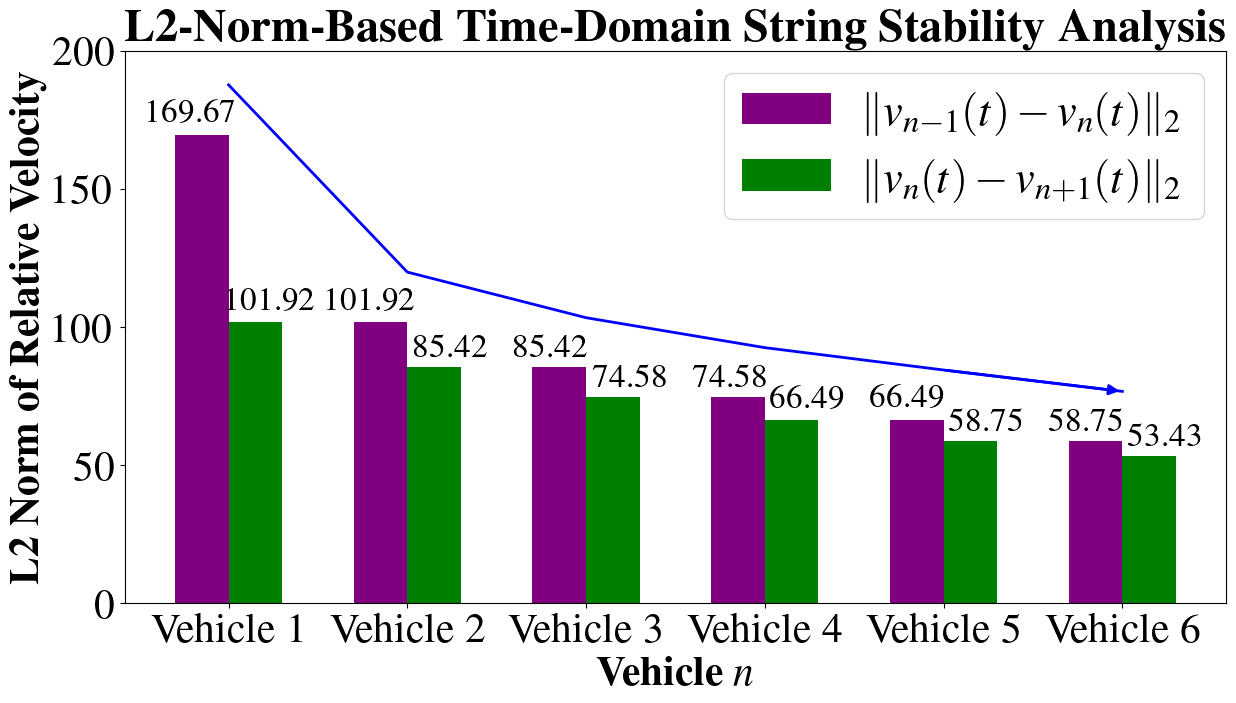

In [30]:
import json
import matplotlib.pyplot as plt
import numpy as np

def plot_bar_with_trend_arrow(data_path):
    """
    Reads JSON data and plots grouped bars with a downward trend arrow.

    Parameters:
        data_path (str): Path to the JSON file containing the data.
    """
    # Load the JSON data
    with open(data_path, 'r') as f:
        data = json.load(f)

    # Extract data for plotting
    vehicles = [d['Vehicle'] for d in data]
    print(vehicles)
    left_norms = [d['left_norm'] for d in data]
    right_norms = [d['right_norm'] for d in data]

    # Trend line will follow the higher value of the two bars for each vehicle
    trend_values = [max(l, r)+18 for l, r in zip(left_norms, right_norms)]
    x = np.arange(len(vehicles))
    width = 0.3

    # Create the plot
    fig, ax = plt.subplots(figsize=(13, 7.68))
    bars1 = ax.bar(x - width/2, left_norms, width, label=r'$\|v_{n-1}(t) - v_n(t)\|_2$', color='purple')
    bars2 = ax.bar(x + width/2, right_norms, width, label=r'$\|v_n(t) - v_{n+1}(t)\|_2$', color='green')

    # Add value labels on top of bars
    for bar in bars1:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2 - 0.05, height+0.05),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=24)
    for bar in bars2:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2 + .09, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=24)

    # Plot the trend line
    ax.plot(x, trend_values, color='blue', linestyle='-', linewidth=2)

    # Add arrow at the end of the trend line
    ax.annotate('',
                xy=(x[-1], trend_values[-1]),
                xytext=(x[-2], trend_values[-2]),
                arrowprops=dict(arrowstyle='-|>', color='blue', lw=2, mutation_scale=15))

    # Labels and legends
    ax.set_xlabel(r'\textbf{Vehicle $n$}')
    ax.set_ylabel(r'\textbf{L2 Norm of Relative Velocity}')
    ax.set_title(r'\textbf{L2-Norm-Based Time-Domain String Stability Analysis}')
    ax.set_xticks(x)
    ax.set_xticklabels([f'Vehicle {i+1}' for i in range(len(vehicles))])
    ax.legend(ncols=1)

    plt.xlim(None, None)
    plt.ylim(0, 200)

    plt.tight_layout()

    save_path = f"../figures/straight/string_stability_test/L2_norm_based_SS.pdf"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=300, format="pdf", bbox_inches='tight')
    print(f"Plot saved to: {save_path}")
    plt.show()

# call function
plot_bar_with_trend_arrow("../analysis/Reports/time_domain_string_stability.json")